# <font color='#018ada'>Entrenamiento con RVC v2 (¡Ahora con copia de seguridad automatica!)</font>
El cuaderno actual está preparado para entrenar con RVC v2, Mangio Fork

<font color='red'>Enlaces que podrían interesarte.</font>
</br>[Tutorial para este cuaderno](https://www.youtube.com/watch?v=gTWA2qyzX7k)
<br>[Tutorial para cuaderno tradicional](https://www.youtube.com/embed/R8-PivPpv8o)
<br>[Transferir archivo de mega a Drive](https://colab.research.google.com/drive/1utTesfmBv-uQ8Upa7TEVpM57kmcq9YN6?usp=sharing)

```js
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
````
PARA ENTRENAR CON LA VERSIÓN 2 SELECCIONE EN LA INTERFAZ "v2"
</br>DEBE ENTRENAR EN 40KHZ PARA ENTRENAR CON LOS NUEVOS PESOS V2 RVC, DE OTRO MODO ES MUY POSIBLE QUE FALLE
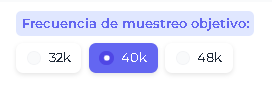

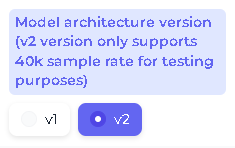

Puede usar tensorboard para realizar un seguimiento de las estadísticas de entrenamiento. La grafica más importante es la pérdida/g/total. Para evitar el sobreentrenamiento, observe el valor y espere hasta que comience a aumentar nuevamente.
</br>Es mucho más probable que ocurra un sobreentrenamiento con pesos v2 (40 minutos alcanzan la marca en alrededor de 900 épocas). Según el creador el modo v2 parece funcionar mejor con conjuntos de datos más grandes debido a esto.

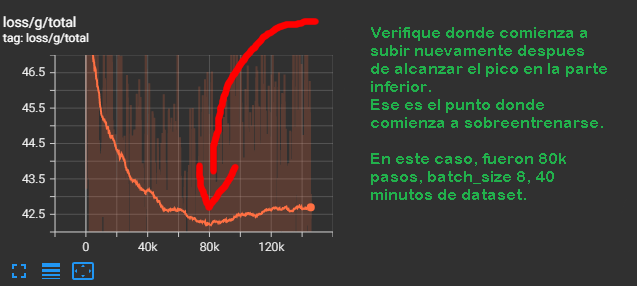

In [ ]:
#@title <font color='#018ada'>Preparar recursos</font>
import os
from urllib.parse import urlparse, parse_qs
from google.oauth2.service_account import Credentials
import gspread
import pandas as pd
from tqdm import tqdm

#************************Obtener lista de modelos****************************
def get_records():
    if not os.path.exists("/content/Retrieval-based-Voice-Conversion-WebUI/stats/peppy-generator-388800-07722f17a188.json"):
      # Download the credentials file for RVC archive sheet
      !mkdir -p /content/Retrieval-based-Voice-Conversion-WebUI/stats/
      !wget -q https://cdn.discordapp.com/attachments/945486970883285045/1114717554481569802/peppy-generator-388800-07722f17a188.json -O /content/Retrieval-based-Voice-Conversion-WebUI/stats/peppy-generator-388800-07722f17a188.json

    # Initialize gspread
    scope = ['https://www.googleapis.com/auth/spreadsheets',
            'https://www.googleapis.com/auth/drive.file',
            'https://www.googleapis.com/auth/drive']

    config_path = '/content/Retrieval-based-Voice-Conversion-WebUI/stats/peppy-generator-388800-07722f17a188.json'

    if os.path.exists(config_path):
        # File exists, proceed with creation of creds and client
        creds = Credentials.from_service_account_file(config_path, scopes=scope)
        client = gspread.authorize(creds)
    else:
        # File does not exist, print message and skip creation of creds and client
        print("Sheet credential file missing.")

    # Open the Google Sheet (this will write any URLs so I can easily track popular models)
    spread = client.open("RVC Archive Sheet")
    sheet = spread.get_worksheet(3)
    records = sheet.get_all_records()
    return records

def run_app():

  models_list = get_records()

  import ipywidgets as widgets
  from ipywidgets import HBox
  from IPython.display import clear_output
  from IPython.core.display import HTML
  #from pydrive.auth import GoogleAuth
  #from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  from mega import Mega
  import shutil
  import unicodedata
  import time
  import os
  import psutil
  import gdown

  #auth.authenticate_user()
  #gauth = GoogleAuth()
  #gauth.credentials = GoogleCredentials.get_application_default()
  #gdrive = GoogleDrive(gauth)

  dataset_success=widgets.Button(description="\u2714 Dataset cargado",disabled=True, button_style="success")
  success=widgets.Button(description="\u2714 Hecho",disabled=True, button_style="success")

  menu_options = ["Cargar un dataset", "Cargar dataset desde un enlace (Drive)", "Cargar un modelo entrenado (Mega/Drive/Huggingface)", "Guardar un modelo","Buscar un modelo","Reinstalar dependencias"]
  menu_options_radio_buttons = widgets.RadioButtons(
    options=menu_options,
    description='¿Que quieres hacer?:',
    disabled=False,
    value="Cargar un dataset",
    layout={'width': 'max-content'},
    style={'description_width': 'initial'}
  )
  menu_button = widgets.Button(description="Continuar")
  load_menu_button = widgets.Button(description="Volver al menu")

  # ----------- Cargar dataset -------------

  dataset_list = []
  dataset_input = widgets.Dropdown(
    options=dataset_list,
    description='Seleccione su dataset:',
    value=None
  )
  external_dataset_url_input = widgets.Text(
          placeholder='https://drive.google.com/file/d/1QaNGZhqyr4-XkV2_I8ngrR5IIATuUwge/view?usp=share_link',
          description='Url del dataset:',
          disabled=False,
          layout={'width': 'max-content'},
          style={'description_width': 'initial'}
  )
  # ------------ Cargar modelo -------------
  model_name_input = widgets.Text(
          placeholder='monlaferte',
          description='Nombre de tu modelo:',
          disabled=False,
          layout={'width': 'max-content'},
          style={'description_width': 'initial'}
  )
  model_url_input = widgets.Text(
          placeholder='https://drive.google.com/file/d/1raXzIFtChq7285VhwVwe3tpcZqvu7PC9/view?usp=share_link',
          description='Url de tu modelo (Drive)',
          disabled=False,
          layout={'width': 'max-content'},
          style={'description_width': 'initial'}
  )

  rvc_repository_input = widgets.Text(
          placeholder='https://github.com/Mangio621/Mangio-RVC-Fork.git',
          description='Url del repositorio',
          disabled=False,
          layout={'width': 'max-content'},
          style={'description_width': 'initial'}
  )
  reinstall_dependencies = widgets.ToggleButtons(
    options=[True, False],
    description='Si/No:'
  )

  # --------------- Guadar modelo ------------------
  # Crear la lista de opciones
  save_model_options = ['Guardar todo', 'Guardar D y G', 'Guardar voz']

  # Crear el widget Dropdown
  save_action_dropdown = widgets.Dropdown(options=save_model_options)

  # --------------- Buscar modelo --------------------
  # Crea un widget de texto para ingresar la palabra de búsqueda
  search_model_input = widgets.Text(
      value='',
      placeholder='¿Que modelo buscas?',
      description='Nombre del modelo:',
      continuous_update=True,
      layout={'width': 'max-content'},
      style={'description_width': 'initial'}
  )
  # -------------------------------------------------
  display(menu_options_radio_buttons)

  # *************** Cargar un dataset ******************
  def remove_special_characters(folder_path):
    for folder_name in os.listdir(folder_path):
        folder_path_old = os.path.join(folder_path, folder_name)
        folder_name_new = ''.join(c for c in folder_name if c.isalnum() or c in ['.', '_'])
        folder_path_new = os.path.join(folder_path, folder_name_new)
        os.rename(folder_path_old, folder_path_new)

  def dataset_button_clicked(b):

    DATASET = dataset_input.value
    if not DATASET:
      print("No puede estar vacio")
      return

    dataset_path = '/content/drive/MyDrive/dataset/' + DATASET

    if not os.path.exists(dataset_path):
      print(f'No existe {DATASET} en {os.path.dirname(dataset_path)}')
      return
    else:
      !mkdir -p /content/dataset
      !unzip -d /content/dataset -B {dataset_path}
      !ls -a /content/dataset/
      !rename 's/(\w+)\.(\w+)~(\d*)/$1_$3.$2/' /content/dataset/*.*~*

      # Eliminar espacios y caracteres especiales en los nombres de las carpetas
      remove_special_characters('/content/dataset')

      clear_output()
      display(dataset_success)
      time.sleep(1)
      display(menu_options_radio_buttons, menu_button)

  # *************** Cargar menu ************************
  def show_menu(b):
    clear_output()
    display(menu_options_radio_buttons, menu_button)

  # **************** Cargar un modelo *********************

  def crear_acceso_directo(enlace):
        # Obtiene el ID del archivo desde el enlace
        id_archivo = enlace.split('/')[-2]

        # Busca la carpeta "temporalmodels"
        carpeta_models = gdrive.ListFile({'q': "title='temporalmodels' and mimeType='application/vnd.google-apps.folder' and trashed=false"}).GetList()

        if len(carpeta_models) == 0:
            # Si la carpeta "temporalmodels" no existe, la crea
            nueva_carpeta = gdrive.CreateFile({
                'title': 'temporalmodels',
                'mimeType': 'application/vnd.google-apps.folder'
            })
            nueva_carpeta.Upload()
            carpeta_models_id = nueva_carpeta['id']
        else:
            carpeta_models_id = carpeta_models[0]['id']

        # Verifica si ya existe un acceso directo con el mismo nombre
        acceso_directo_existente = gdrive.ListFile({'q': f"title='temporalmodel' and '{carpeta_models_id}' in parents and mimeType='application/vnd.google-apps.shortcut' and trashed=false"}).GetList()

        if len(acceso_directo_existente) > 0:
            # Si ya existe un acceso directo con el mismo nombre, lo reemplaza
            acceso_directo = acceso_directo_existente[0]
            acceso_directo['shortcutDetails'] = {'targetId': id_archivo}
            acceso_directo.Upload()
        else:
            # Si no existe un acceso directo con el mismo nombre, lo crea
            enlace_simbolico = gdrive.CreateFile({
                'title': 'temporalmodel',
                'mimeType': 'application/vnd.google-apps.shortcut',
                'shortcutDetails': {
                    'targetId': id_archivo
                },
                'parents': [{'id': carpeta_models_id}]
            })
            enlace_simbolico.Upload()

        return True


  def model_button_cliked(b):
    import shutil, os
    import subprocess

    url= model_url_input.value

    zips_path='/content/zips/'
    !mkdir -p $zips_path

    downloaded_model = False
    if url != '':
      if "drive.google.com" in url:
        if "file/d/" in url:
          file_id = url.split("file/d/")[1].split("/")[0]
        elif "id=" in url:
          file_id = url.split("id=")[1].split("&")[0]
        else:
          print("Enlace de Google Drive no válido.")
          file_id = None
        if file_id:
          %cd /content/zips
          filename = gdown.download(url=f"https://drive.google.com/uc?id={file_id}", fuzzy=True)
          if not filename:
            print("Parece que el enlace ha sido demasiado usado, intentando descargar con el método de acceso directo.")
            print("Por favor usa el paso 2b o sigue este tutorial para obtener una url nueva: https://www.youtube.com/watch?v=dwhh8APJCxA")
            raise("Enlace no valido")

          unzipped_dir = os.path.join('/content/unzips', filename)
          downloaded_model = True

      elif "mega.nz" in url:
        if "#!" in url:
          file_id = url.split("#!")[1].split("!")[0]
        elif "file/" in url:
          file_id = url.split("file/")[1].split("/")[0]
        else:
          print("Enlace de Mega no válido.")
          file_id = None
        if file_id:
          m = Mega()
          print("Descargando desde mega...")
          file_path = m.download_url(url, zips_path)
          unzipped_dir = file_path
          downloaded_model = True

      else:
        %cd /content/zips
        !wget ${"'"+url+"'"}
        filename = os.path.basename(url.replace("%20"," "))
        new_filename = filename.replace(" ","_")
        os.rename(f"/content/zips/{filename}",f"/content/zips/{new_filename}")
        unzipped_dir = os.path.join('/content/unzips', new_filename)
        downloaded_model = True

      # Directorio donde se descomprimió el archivo
      MODELNAME = os.path.basename(os.path.normpath(str(unzipped_dir).replace(".zip","")))

      weights_dir = '/content/Retrieval-based-Voice-Conversion-WebUI/weights'
      logs_dir = os.path.join("/content/Retrieval-based-Voice-Conversion-WebUI/logs/", MODELNAME)
      if os.path.exists(logs_dir):
        # Si el archivo ya existe, eliminarlo
        shutil.rmtree(logs_dir)

      if not os.path.exists(weights_dir):
        os.mkdir(weights_dir)

      os.mkdir(logs_dir)

      if downloaded_model:
        zip_file = os.path.join(zips_path, MODELNAME + ".zip")
        unzipped_dir = os.path.join("/content/unzips", MODELNAME)

        # Eliminar el directorio de destino si ya existe
        if os.path.exists(unzipped_dir):
          shutil.rmtree(unzipped_dir)

        # Descomprimir el archivo ZIP utilizando el nombre MODELNAME
        shutil.unpack_archive(zip_file, extract_dir="/content/unzips/" +  MODELNAME, format='zip')
      else:
        raise Exception("Error descargando el modelo")

      logs_folders = ['0_gt_wavs','1_16k_wavs','2a_f0','2b-f0nsf','3_feature256','3_feature768']

      index_file = False
      model_file = False
      D_file = False
      G_file = False

      model_name = MODELNAME
      # Mover el archivo D, G y added_*.index
      for path, subdirs, files in os.walk(unzipped_dir):
        for item in files:
          item_path = os.path.join(path, item)
          if not 'G_' in item and not 'D_' in item and item.endswith('.pth'):
            model_file = True
            model_name = item.replace(".pth","")
            shutil.rmtree(logs_dir)
            logs_dir = f"/content/Retrieval-based-Voice-Conversion-WebUI/logs/{model_name}"
            os.mkdir(logs_dir)
            if not os.path.exists(weights_dir):
              os.mkdir(weights_dir)
            if os.path.exists(os.path.join(weights_dir, item)):
              os.remove(os.path.join(weights_dir, item))
            if os.path.exists(item_path):
              shutil.move(item_path, weights_dir)

      # Mover el model.pth y renombrar folder
      for path, subdirs, files in os.walk(unzipped_dir):
        for item in files:
          item_path = os.path.join(path, item)
          if item.startswith('added_') and item.endswith('.index'):
            index_file = True
            if os.path.exists(item_path):
              shutil.move(item_path, logs_dir)
          if 'D_' in item and item.endswith('.pth'):
            D_file = True
            if os.path.exists(item_path):
              shutil.move(item_path, logs_dir)
          if 'G_' in item and item.endswith('.pth'):
            G_file = True
            if os.path.exists(item_path):
              shutil.move(item_path, logs_dir)
          if item.startswith('total_fea.npy'):
            if os.path.exists(item_path):
              shutil.move(item_path, logs_dir)

      # Mover todos los folders excepto 'eval'
      for path, subdirs, files in os.walk(unzipped_dir):
        print(subdirs)
        for folder in subdirs:
          print(folder)
          if folder in logs_folders:
            item_path = os.path.join(path, folder)
            shutil.move(item_path, logs_dir)

      #!rm -r /content/Retrieval-based-Voice-Conversion-WebUI/logs/{MODELNAME}
      !rm -r /content/unzips/
      !rm -r /content/zips/

      clear_output()
      display(success)

      if model_file:
        if index_file:
          print("El modelo funciona para inferencia, y tiene el archivo .index")
        else:
          print("El modelo funciona para inferencia, pero no tiene el archivo .index")
      if D_file and G_file:
        print("El modelo puede ser reentrenado.")

      clear_output()
      display(success)
      time.sleep(1)
      display(menu_options_radio_buttons, menu_button)
    else:
      print("La url no puede estar vacia.")

  # ******************** Guardar modelo *******************
  def save_model_clicked(b):
    MODELNAME = model_name_input.value
    save_action = save_action_dropdown.value
    %cd /content
    #print(MODELNAME)
    import shutil, os

    if os.path.exists('/content/zips'):
      shutil.rmtree('/content/zips')

    src = os.path.join("/content/Retrieval-based-Voice-Conversion-WebUI/logs",MODELNAME)
    dst = os.path.join("/content/zips/",MODELNAME)

    if save_action == "Guardar todo":
      print("Esto puede tomar unos minutos, por favor espere...")
      shutil.copytree(src, dst)
      !cp /content/Retrieval-based-Voice-Conversion-WebUI/weights/{MODELNAME}.pth /content/zips/{MODELNAME}/
    if save_action == "Guardar D y G":
      !mkdir -p /content/zips/{MODELNAME}/
      !cp /content/Retrieval-based-Voice-Conversion-WebUI/logs/{MODELNAME}/D_*.pth /content/zips/{MODELNAME}/
      !cp /content/Retrieval-based-Voice-Conversion-WebUI/logs/{MODELNAME}/G_*.pth /content/zips/{MODELNAME}/
      !cp /content/Retrieval-based-Voice-Conversion-WebUI/logs/{MODELNAME}/added_*.index /content/zips/{MODELNAME}/
      !cp /content/Retrieval-based-Voice-Conversion-WebUI/weights/{MODELNAME}.pth /content/zips/{MODELNAME}/
    if save_action == "Guardar voz":
      !mkdir -p /content/zips/{MODELNAME}/
      !cp /content/Retrieval-based-Voice-Conversion-WebUI/logs/{MODELNAME}/added_*.index /content/zips/{MODELNAME}/
      !cp /content/Retrieval-based-Voice-Conversion-WebUI/weights/{MODELNAME}.pth /content/zips/{MODELNAME}/


    !mkdir -p /content/drive/MyDrive/RVC/

    %cd /content/zips
    !zip -r {MODELNAME}.zip {MODELNAME}
    shutil.move(f'/content/zips/{MODELNAME}.zip',f'/content/drive/MyDrive/RVC/{MODELNAME}.zip')
    %cd /content
    shutil.rmtree("/content/zips")
    clear_output()
    display(success)
    time.sleep(1)
    display(menu_options_radio_buttons, menu_button)

  # ************************ Descargar un dataset desde url ***********
  def save_external_dataset_clicked(b):

    url = external_dataset_url_input.value
    if url != '':
      if "drive.google.com" in url:
        if "file/d/" in url:
          file_id = url.split("file/d/")[1].split("/")[0]
        elif "id=" in url:
          file_id = url.split("id=")[1].split("&")[0]
        else:
          print("Enlace de Google Drive no válido.")
          file_id = None
        if file_id:
          %cd /content/drive/MyDrive/dataset
          filename = gdown.download(url=f"https://drive.google.com/uc?id={file_id}", fuzzy=True)
          if not filename:
            print("Parece que el enlace ha sido demasiado usado, intentando descargar con el método de acceso directo.")
            print("Puedes usar el siguiente tutorial para sacarle una copia al archivo original: https://www.youtube.com/watch?v=dwhh8APJCxA")

          file_path = f"/content/drive/MyDrive/dataset/{filename}"
          # Normalizar el nombre del archivo
          normalized_filename = unicodedata.normalize('NFKD', filename).encode('ascii', 'ignore').decode('ascii')
          # Eliminar espacios y caracteres especiales
          sanitized_filename = ''.join(c for c in normalized_filename if c.isalnum() or c in ['.', '_'])
          # Renombrar el archivo
          new_filename = os.path.join(f"/content/drive/MyDrive/dataset", sanitized_filename)
          os.rename(file_path, new_filename)
          filename = new_filename

      elif "mega.nz" in url:
        if "#!" in url:
          file_id = url.split("#!")[1].split("!")[0]
        elif "file/" in url:
          file_id = url.split("file/")[1].split("/")[0]
        else:
          print("Enlace de Mega no válido.")
          file_id = None
        if file_id:
          m = Mega()
          print("Descargando desde mega...")
          file_path = m.download_url(url, "/content/drive/MyDrive/dataset")

    clear_output()
    display(success)

    time.sleep(1)
    display(menu_options_radio_buttons, menu_button)

  def search_model(modelname):
      clear_output()
      if modelname.strip() != "":
        results = []
        if len(models_list) > 0:
          for row in range(len(models_list)):
            title = str(models_list[row]['Filename']).replace("v1","").replace("v2","").replace("_"," ").replace("-"," ").lower()
            if modelname.lower() in title.lower():
              results.append(models_list[row])
        for model in results:
          print(f"Nombre: {model['Filename']}")
          url =  f"BASE: <{model['URL'].strip().replace(' ','%20')}>\n"
          for alt in range(1, 18):
              pos = f'Alt URL #{alt}'
              if model[pos].strip() and len(url) < 1300:
                  texto = model[pos].strip()
                  index = texto[1:len(texto)].find("https://")
                  if not index or index == -1:
                      index = len(texto)
                  url += str(f"OPCIÓN #{alt}: <{texto[0:index + 1].replace(' ','%20')}>\n")
          print(f"URL: {url}")


  def menu_button_clicked(b):
    if(menu_options_radio_buttons.value == 'Cargar un dataset'):
      clear_output()

      dataset_list = []
      dataset_dir = os.listdir('/content/drive/MyDrive/dataset')
      for file in dataset_dir:
        if file.endswith('.zip'):
          dataset_list.append(file)

      dataset_input.options = dataset_list
      display(dataset_input)

      load_dataset_button = widgets.Button(description="Continuar")
      load_dataset_button.on_click(dataset_button_clicked)
      contenedor = HBox([load_menu_button, load_dataset_button])
      display(contenedor)

    elif(menu_options_radio_buttons.value == 'Cargar un modelo entrenado (Mega/Drive/Huggingface)'):
      clear_output()

      display(model_url_input)
      load_model_button = widgets.Button(description="Continuar")
      load_model_button.on_click(model_button_cliked)
      contenedor = HBox([load_menu_button, load_model_button])
      display(contenedor)

    elif(menu_options_radio_buttons.value == 'Guardar un modelo'):
      clear_output()
      save_model_button = widgets.Button(description="Guardar")
      save_model_button.on_click(save_model_clicked)
      contenedor = HBox([load_menu_button, save_model_button])
      display(contenedor, model_name_input, save_action_dropdown)

    elif (menu_options_radio_buttons.value == 'Cargar dataset desde un enlace (Drive)'):
      clear_output()
      save_external_dataset_button = widgets.Button(description="Descargar")
      save_external_dataset_button.on_click(save_external_dataset_clicked)
      contenedor = HBox([load_menu_button, save_external_dataset_button])
      display(external_dataset_url_input, contenedor)

    elif (menu_options_radio_buttons.value == 'Buscar un modelo'):
      clear_output()
      # Llama automáticamente a la función buscar_palabra cuando cambia el valor del widget
      display(load_menu_button)
      widgets.interact(search_model, modelname=search_model_input)

    elif reinstall_dependencies.value and menu_options_radio_buttons.value == 'Reinstalar dependencias':
      clear_output()
      install_dependencies()
      clear_output()
      display(success)
      run_app()

  menu_button.on_click(menu_button_clicked)
  display(menu_button)
  load_menu_button.on_click(show_menu)

def install_dependencies():
  print('Iniciando...')
  import subprocess
  packages = ['build-essential', 'python3-dev', 'ffmpeg', 'aria2']
  pip_packages = ['pip', 'setuptools', 'wheel', 'httpx==0.23.0', 'faiss-gpu', 'fairseq', 'gradio==3.34.0',
                  'ffmpeg', 'ffmpeg-python', 'praat-parselmouth', 'pyworld', 'numpy==1.23.5',
                  'numba==0.56.4', 'librosa==0.9.2', 'mega.py', 'gdown', 'onnxruntime', 'pyngrok==4.1.12', 'tensorboardX']

  print("Actualizando e instalando paquetes del sistema...")
  for package in packages:
      print(f"Instalando {package}...")
      subprocess.check_call(['apt-get', 'install', '-qq', '-y', package])

  print("Actualizando e instalando paquetes de pip... (Esto puede tomar unos minutos...)")
  for package in pip_packages:
      print(f"Instalando {package}...")
      subprocess.check_call(['pip', 'install', '--upgrade'] + pip_packages)

  print('Paquetes actualizados.')

  import ipywidgets as widgets
  from IPython.display import clear_output
  import os, shutil
  from termcolor import cprint
  success=widgets.Button(description="\u2714 Completado",disabled=True, button_style="success")

  pretrainded = False
  pretrainded_v2 = False
  weights = False
  hubert_base = False

  print("Cambiando de repo...")
  temporal_folder = "/content/temporal_rvc_folder"
  if os.path.exists(temporal_folder):
    shutil.rmtree(temporal_folder)
  os.mkdir(temporal_folder)

  print("Temporal folder creado")
  if os.path.exists("/content/Retrieval-based-Voice-Conversion-WebUI"):
    if os.path.exists("/content/Retrieval-based-Voice-Conversion-WebUI/pretrained"):
      shutil.move("/content/Retrieval-based-Voice-Conversion-WebUI/pretrained","/content/temporal_rvc_folder/pretrained")
      pretrainded = True
    if os.path.exists("/content/Retrieval-based-Voice-Conversion-WebUI/pretrained_v2"):
      shutil.move("/content/Retrieval-based-Voice-Conversion-WebUI/pretrained_v2","/content/temporal_rvc_folder/pretrained_v2")
      pretrainded_v2 = True
    if os.path.exists("/content/Retrieval-based-Voice-Conversion-WebUI/uvr5_weights"):
      shutil.move("/content/Retrieval-based-Voice-Conversion-WebUI/uvr5_weights","/content/temporal_rvc_folder/uvr5_weights")
      weights = True
    if os.path.exists("/content/Retrieval-based-Voice-Conversion-WebUI/hubert_base.pt"):
      shutil.move("/content/Retrieval-based-Voice-Conversion-WebUI/hubert_base.pt","/content/temporal_rvc_folder/hubert_base.pt")
      hubert_base = True

    shutil.rmtree("/content/Retrieval-based-Voice-Conversion-WebUI")
  else:
    pretrainded = False
    pretrainded_v2 = False
    weights = False
    hubert_base = False

  %cd /content/
  print("Descargando repositorio...")

  # Cambiar el directorio actual a /content/
  os.chdir('/content/')

  # Clonar el ultimó codigo de Mangio621/Mangio-RVC-Fork
  !git clone https://github.com/Mangio621/Mangio-RVC-Fork.git Retrieval-based-Voice-Conversion-WebUI &> /dev/null
  os.chdir('/content/Retrieval-based-Voice-Conversion-WebUI')
  print("Actualizando repo a commit a5b45691957f7a4b2615bcc02ea453490023fac3")
  !git checkout a5b45691957f7a4b2615bcc02ea453490023fac3 &> /dev/null

  if os.path.exists("/content/Retrieval-based-Voice-Conversion-WebUI/pretrained"):
    shutil.rmtree("/content/Retrieval-based-Voice-Conversion-WebUI/pretrained")
  if os.path.exists("/content/Retrieval-based-Voice-Conversion-WebUI/pretrained_v2"):
    shutil.rmtree("/content/Retrieval-based-Voice-Conversion-WebUI/pretrained_v2")
  if os.path.exists("/content/Retrieval-based-Voice-Conversion-WebUI/uvr5_weights"):
    shutil.rmtree("/content/Retrieval-based-Voice-Conversion-WebUI/uvr5_weights")


  os.chdir('/content')
  # Doescargar el folder torchcrepe de maxrmorrison/torchcrepe
  !git clone https://github.com/maxrmorrison/torchcrepe.git &> /dev/null
  !mv torchcrepe/torchcrepe /content/Retrieval-based-Voice-Conversion-WebUI/
  !rm -rf torchcrepe  # Borrar el folder de torchcrepe

  # Cambiar el directorio actual a /content/Retrieval-based-Voice-Conversion-WebUI
  os.chdir('/content/Retrieval-based-Voice-Conversion-WebUI')

  %cd /content/Retrieval-based-Voice-Conversion-WebUI

  print("Descargando modelos base...")
  if pretrainded:
    shutil.move("/content/temporal_rvc_folder/pretrained", "/content/Retrieval-based-Voice-Conversion-WebUI/")
  else:
    !mkdir -p pretrained
    !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained/D32k.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/pretrained -o D32k.pth > /dev/null 2>&1
    !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained/D40k.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/pretrained -o D40k.pth > /dev/null 2>&1
    !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained/D48k.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/pretrained -o D48k.pth > /dev/null 2>&1
    !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained/G32k.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/pretrained -o G32k.pth > /dev/null 2>&1
    !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained/G40k.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/pretrained -o G40k.pth > /dev/null 2>&1
    !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained/G48k.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/pretrained -o G48k.pth > /dev/null 2>&1
    !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained/f0D32k.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/pretrained -o f0D32k.pth > /dev/null 2>&1
    !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained/f0D40k.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/pretrained -o f0D40k.pth > /dev/null 2>&1
    !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained/f0D48k.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/pretrained -o f0D48k.pth > /dev/null 2>&1
    !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained/f0G32k.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/pretrained -o f0G32k.pth > /dev/null 2>&1
    !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained/f0G40k.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/pretrained -o f0G40k.pth > /dev/null 2>&1
    !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained/f0G48k.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/pretrained -o f0G48k.pth > /dev/null 2>&1

  if pretrainded_v2:
    shutil.move("/content/temporal_rvc_folder/pretrained_v2", "/content/Retrieval-based-Voice-Conversion-WebUI/")
  else:
    !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained_v2/D40k.pth -d /content/Retrieval-based-Voice-Conversion-WebUI/pretrained_v2 -o D40k.pth > /dev/null 2>&1
    !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained_v2/G40k.pth -d /content/Retrieval-based-Voice-Conversion-WebUI/pretrained_v2 -o G40k.pth > /dev/null 2>&1
    !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained_v2/f0D40k.pth -d /content/Retrieval-based-Voice-Conversion-WebUI/pretrained_v2 -o f0D40k.pth > /dev/null 2>&1
    !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/pretrained_v2/f0G40k.pth -d /content/Retrieval-based-Voice-Conversion-WebUI/pretrained_v2 -o f0G40k.pth > /dev/null 2>&1

  if weights:
    shutil.move("/content/temporal_rvc_folder/uvr5_weights", "/content/Retrieval-based-Voice-Conversion-WebUI/")
  else:
    !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/uvr5_weights/HP2-人声vocals+非人声instrumentals.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/uvr5_weights -o HP2-人声vocals+非人声instrumentals.pth > /dev/null 2>&1
    !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/uvr5_weights/HP5-主旋律人声vocals+其他instrumentals.pth -d /content//Retrieval-based-Voice-Conversion-WebUI/uvr5_weights -o HP5-主旋律人声vocals+其他instrumentals.pth > /dev/null 2>&1

  if hubert_base:
    shutil.move("/content/temporal_rvc_folder/hubert_base.pt", "/content/Retrieval-based-Voice-Conversion-WebUI/hubert_base.pt")
  else:
    !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lj1995/VoiceConversionWebUI/resolve/main/hubert_base.pt -d /content//Retrieval-based-Voice-Conversion-WebUI -o hubert_base.pt > /dev/null 2>&1

  #clear_output()
  display(success)

  cprint("Conectando con google drive...","blue")

  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  !mkdir -p /content/drive/MyDrive/RVC
  !mkdir -p /content/drive/MyDrive/dataset
  !mkdir -p /content/EasyDataset
  shutil.rmtree("/content/temporal_rvc_folder")

  clear_output()
  display(success)
  print("Carga tu dataset en la carpeta 'dataset' de tu drive")
  run_app()

try:
  run_app()
except ImportError:
  install_dependencies()


In [ ]:
#@title <font color='#018ada'>Interfaz de gradio</font>
import os
import threading
import time
import shutil
import hashlib

GOOGLE_DRIVE_PATH = '/content/drive/MyDrive/RVC_Backup' # cambiar a tu ubicacion de drive
LOGS_FOLDER = '/content/Retrieval-based-Voice-Conversion-WebUI/logs'
WEIGHTS_FOLDER = '/content/Retrieval-based-Voice-Conversion-WebUI/weights'
#@markdown Si google colab se desconectó mientras se entrenaba el modelo, puedes cargar la última copia de seguridad guardada en tu Drive
cargar_backup = False #@param{type: 'boolean'}
#@markdown Si deseas crear un backup automatico durante el entrenamiento
crear_backup_automatico = False #@param{type: 'boolean'}
#@markdown Para obtener estadisticas de como va el entrenamiento
usar_tensorboard = False #@param{type: 'boolean'}

# Buscar modelos guardados en drive y restaurarlos en el folder /rvc
def import_google_drive_backup():
    version = "1"
    print("Importando backup de Google Drive...")
    weights_exist = False

    for root, dirs, files in os.walk(GOOGLE_DRIVE_PATH):
        for filename in files:
            filepath = os.path.join(root, filename)
            # Si existen archivos de backups meterlos en la carpeta rvc/logs con metadatos
            if os.path.isfile(filepath) and not filepath.startswith(os.path.join(GOOGLE_DRIVE_PATH, 'weights')):
                backup_filepath = os.path.join(LOGS_FOLDER, os.path.relpath(filepath, GOOGLE_DRIVE_PATH))
                backup_folderpath = os.path.dirname(backup_filepath)
                if not os.path.exists(backup_folderpath):
                    os.makedirs(backup_folderpath)
                    print(f'Se ha creado backup del folder: {backup_folderpath}', flush=True)
                shutil.copy2(filepath, backup_filepath) # Copiar archivo con metadatos
                if '3_feature_768' in filepath:
                  version = "2"
                print(f'Importado archivo de backup: {filename}')
            # Si el archivo actual pertenece a pesos entonces meterlo a rvc/weights con metadatos
            elif filepath.startswith(os.path.join(GOOGLE_DRIVE_PATH, 'weights')) and filename.endswith('.pth'):
                weights_exist = True
                weights_filepath = os.path.join(WEIGHTS_FOLDER, os.path.relpath(filepath, os.path.join(GOOGLE_DRIVE_PATH, 'weights')))
                weights_folderpath = os.path.dirname(weights_filepath)
                if not os.path.exists(weights_folderpath):
                    os.makedirs(weights_folderpath)
                    print(f'Folder weights creado: {weights_folderpath}', flush=True)
                shutil.copy2(filepath, weights_filepath) # Copiar los metadatos del archivo
                print(f'Archivo importado desde weights: {filename}')

    # if weights_exist:
    #     print("Pesos copiados del backup de Google Drive a la carpeta de pesos local.")
    # else:
    #     print("No se encontraron pesos en el backup de Google Drive.")
    print("Importación del backup completado.")
    print("Se detectó que el modelo fue entrenado en la versión " + str(version))

# Importar modelos antes de iniciar el servidor
if cargar_backup:
  import_google_drive_backup()

def empezar_servidor():
    %cd /content/Retrieval-based-Voice-Conversion-WebUI
    if usar_tensorboard:
      %load_ext tensorboard
      %tensorboard --logdir /content/Retrieval-based-Voice-Conversion-WebUI/logs
    !mkdir -p /content/Retrieval-based-Voice-Conversion-WebUI/audios
    !python3 infer-web.py --colab --pycmd python3


def copiar_folder_pesos_a_drive():
    # Verificar si no existe el folder weights en el folder backup
    destination_folder = os.path.join(GOOGLE_DRIVE_PATH, 'weights')
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    #
    num_copied = 0
    # Copiar los archivos .pth qsi aún no existen en drive
    for filename in os.listdir(WEIGHTS_FOLDER):
        if filename.endswith('.pth'):
            source_file = os.path.join(WEIGHTS_FOLDER, filename)
            destination_file = os.path.join(destination_folder, filename)
            if not os.path.exists(destination_file):
                shutil.copy2(source_file, destination_file)
                num_copied += 1
                print(f"{filename} copiado a Google Drive!")

    # if num_copied == 0:
    #     print("No se encontraron nuevos modelos terminados para copiar.")
    # else:
    #     print(f"¡Terminó de copiar {num_copied} archivos a Google Drive!")


def backup_files():
    print("Iniciando bucle de copia de seguridad...")
    last_backup_timestamps_path = os.path.join(LOGS_FOLDER, 'last_backup_timestamps.txt')
    fully_updated = False  # booleano para rastrear si todos los archivos están actualizados
    try:
        with open(last_backup_timestamps_path, 'r') as f:
            last_backup_timestamps = dict(line.strip().split(':') for line in f)
    except:
        last_backup_timestamps = {}
    while True:
        updated = False # marca para verificar si se actualizó algún archivo
        # Recorrer /content/RVC
        for root, dirs, files in os.walk(LOGS_FOLDER):
            for filename in files:
                if filename != 'last_backup_timestamps.txt':
                    filepath = os.path.join(root, filename)
                    if os.path.isfile(filepath):
                        backup_filepath = os.path.join(GOOGLE_DRIVE_PATH, os.path.relpath(filepath, LOGS_FOLDER))
                        backup_folderpath = os.path.dirname(backup_filepath)
                        if not os.path.exists(backup_folderpath):
                            os.makedirs(backup_folderpath)
                            print(f'Se ha creado un folder backup de: {backup_folderpath}', flush=True)
                        # se comprueba si el archivo ha cambiado desde el ultimo backup
                        last_backup_timestamp = last_backup_timestamps.get(filepath)
                        current_timestamp = os.path.getmtime(filepath)
                        if last_backup_timestamp is None or float(last_backup_timestamp) < current_timestamp:
                            shutil.copy2(filepath, backup_filepath) # copiar archivo con metadata
                            last_backup_timestamps[filepath] = str(current_timestamp) # actualizar las marcas de tiempo
                            if last_backup_timestamp is None:
                              extension = filename.split(".")[-1]
                              # if extension != "npy" and extension != "pt":
                              #   print(f'Se ha creado backup de: {filename}')
                            else:
                              extension = filename.split(".")[-1]
                              # if extension != "npy" and extension != "pt":
                              #   print(f'Se ha actualizado el backup de: {filename}')
                            updated = True
                            fully_updated = False  # si un archivo se actualiza, todos los archivos no están actualizados

        # verificar si se eliminaron archivos en Colab y eliminarlos del backup
        for filepath in list(last_backup_timestamps.keys()):
            if not os.path.exists(filepath):
                backup_filepath = os.path.join(GOOGLE_DRIVE_PATH, os.path.relpath(filepath, LOGS_FOLDER))
                if os.path.exists(backup_filepath):
                    os.remove(backup_filepath)
                    print(f'Deleted file: {filepath}')
                del last_backup_timestamps[filepath]
                updated = True
                fully_updated = False  # si se elimina un archivo, todos los archivos no están actualizados
        if not updated and not fully_updated:
            print("Los archivos están actualizados.")
            fully_updated = True  # si todos los archivos están actualizados, establecer el booleano en True
            copiar_folder_pesos_a_drive()
            sleep_time = 30
        else:
            sleep_time = 1
        with open(last_backup_timestamps_path, 'w') as f:
            for filepath, timestamp in last_backup_timestamps.items():
                f.write(f'{filepath}:{timestamp}\n')
        time.sleep(sleep_time) # esperar 30 segundos antes de verificar nuevamente, o 1s si no está completamente actualizado para acelerar los backup

if crear_backup_automatico:
  # Empezar el servidor en un hilo separadp
  web_server_thread = threading.Thread(target=empezar_servidor)
  web_server_thread.start()

  # Ejecutar el ciclo de backup en el hilo principal
  backup_files()
else:
  empezar_servidor()

In [ ]:
#@title <font color="#018ada">Cargar modelo desde url muy usada (Permiso de lectura y escritura avanzada en drive - OPCIONAL)</font>
#@markdown **Nota:** Si el modelo pesa más de 2gb puede tardar hasta 5 minutos
import os
import shutil
from IPython.display import clear_output
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import time
import ipywidgets as widgets
success=widgets.Button(description="\u2714 Hecho",disabled=True, button_style="success")

%cd ~
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
gdrive = GoogleDrive(gauth)

def crear_acceso_directo(enlace):
        if os.path.exists('/content/drive/MyDrive/temporalmodels'):
          shutil.rmtree('/content/drive/MyDrive/temporalmodels')

        # Obtiene el ID del archivo desde el enlace
        id_archivo = enlace.split('/')[-2]

        # Busca la carpeta "tempmodel"
        carpeta_models = gdrive.ListFile({'q': "title='temporalmodels' and mimeType='application/vnd.google-apps.folder' and trashed=false"}).GetList()

        # Si la carpeta "temporalmodels" no existe, la crea
        nueva_carpeta = gdrive.CreateFile({
            'title': 'temporalmodels',
            'mimeType': 'application/vnd.google-apps.folder'
        })
        nueva_carpeta.Upload()
        carpeta_models_id = nueva_carpeta['id']

        # Verifica si ya existe un acceso directo con el mismo nombre
        acceso_directo_existente = gdrive.ListFile({'q': f"title='tempmodel' and '{carpeta_models_id}' in parents and mimeType='application/vnd.google-apps.shortcut' and trashed=false"}).GetList()

        if len(acceso_directo_existente) > 0:
            # Si ya existe un acceso directo con el mismo nombre, lo reemplaza
            acceso_directo = acceso_directo_existente[0]
            acceso_directo['shortcutDetails'] = {'targetId': id_archivo}
            acceso_directo.Upload()
        else:
            # Si no existe un acceso directo con el mismo nombre, lo crea
            enlace_simbolico = gdrive.CreateFile({
                'mimeType': 'application/vnd.google-apps.shortcut',
                'shortcutDetails': {
                    'targetId': id_archivo
                },
                'parents': [{'id': carpeta_models_id}]
            })
            enlace_simbolico.Upload()
            enlace_simbolico.FetchMetadata()

url = "https://drive.google.com/file/d/1WVVV_v2GTQkGQzl9dLj1avSttoVr2l3G/view" #@param {type: 'string'}
print("Creando acceso directo...")
crear_acceso_directo(url)

while not os.path.exists("/content/drive/MyDrive/temporalmodels"):
  time.sleep(1)

if os.path.exists("/content/tempfolder"):
  shutil.rmtree("/content/tempfolder")
if os.path.exists("/content/Models"):
  shutil.rmtree("/content/Models")

os.mkdir("/content/tempfolder")
os.mkdir("/content/Models")
print("Comprimiendo archivo (Esto puede tomar unos minutos)...")
#Comprimir el acceso directo en /content/tempfolder/xxx.zip
shutil.make_archive(f"/content/tempfolder/xxx", "zip", "/content/drive/MyDrive/temporalmodels")
print(f"Copiando a /content/Models...")
#Descomprimir el archivo /content/tempfolder/xxx.zip en /content/Models/
shutil.unpack_archive(f"/content/tempfolder/xxx.zip", f"/content/Models")

!rm -r /content/drive/MyDrive/Models
!rm -r /content/drive/MyDrive/temporalmodels

# Obtener una lista de todos los archivos en el directorio
models = os.listdir("/content/Models")
models_zip = [archivo for archivo in models if archivo.endswith(".zip")]

for MODELNAME in models_zip:
  print("Cargando modelo...")
  MODELNAME = MODELNAME.replace(".zip","")

  # Directorio donde se descomprimió el archivo
  dest_path = os.path.join("/content/Retrieval-based-Voice-Conversion-WebUI/logs/", MODELNAME)
  if os.path.exists(dest_path):
    # Si el archivo ya existe, eliminarlo
    shutil.rmtree(dest_path)
  !mkdir -p $dest_path

  zip_file = os.path.join('/content/Models', MODELNAME + ".zip")
  unzipped_dir = os.path.join("/content/unzips", MODELNAME)

  # Eliminar el directorio de destino si ya existe
  if os.path.exists(unzipped_dir):
    shutil.rmtree(unzipped_dir)
  # Descomprimir el archivo ZIP utilizando el nombre MODELNAME
  shutil.unpack_archive(zip_file, extract_dir="/content/unzips/" +  MODELNAME, format='zip')

  # Directorio donde se moverán los folders
  logs_dir = os.path.join('/content/Retrieval-based-Voice-Conversion-WebUI/logs', MODELNAME)
  weights_dir = '/content/Retrieval-based-Voice-Conversion-WebUI/weights'
  logs_folders = ['0_gt_wavs','1_16k_wavs','2a_f0','2b-f0nsf','3_feature256']

  index_file = False
  model_file = False
  D_file = False
  G_file = False

  model_name = MODELNAME
   # Mover el archivo D, G y added_*.index
  for path, subdirs, files in os.walk(unzipped_dir):
    for item in files:
      item_path = os.path.join(path, item)
      if not 'G_' in item and not 'D_' in item and item.endswith('.pth'):
        model_file = True
        model_name = item.replace(".pth","")
        shutil.rmtree(logs_dir)
        logs_dir = f"/content/Retrieval-based-Voice-Conversion-WebUI/logs/{model_name}"
        os.mkdir(logs_dir)
        if not os.path.exists(weights_dir):
          os.mkdir(weights_dir)
        if os.path.exists(os.path.join(weights_dir, item)):
          os.remove(os.path.join(weights_dir, item))
        if os.path.exists(item_path):
          shutil.move(item_path, weights_dir)

  # Mover el model.pth y renombrar folder
  for path, subdirs, files in os.walk(unzipped_dir):
    for item in files:
      item_path = os.path.join(path, item)
      if item.startswith('added_') and item.endswith('.index'):
        index_file = True
        if os.path.exists(item_path):
          shutil.move(item_path, logs_dir)
      if 'D_' in item and item.endswith('.pth'):
        D_file = True
        if os.path.exists(item_path):
          shutil.move(item_path, logs_dir)
      if 'G_' in item and item.endswith('.pth'):
        G_file = True
        if os.path.exists(item_path):
          shutil.move(item_path, logs_dir)
      if item.startswith('total_fea.npy'):
        if os.path.exists(item_path):
          shutil.move(item_path, logs_dir)

  # Mover todos los folders excepto 'eval'
  for path, subdirs, files in os.walk(unzipped_dir):
    for folder in subdirs:
      if folder in logs_folders:
        item_path = os.path.join(path, folder)
        shutil.move(item_path, logs_dir)


  #!rm -r /content/Retrieval-based-Voice-Conversion-WebUI/logs/{MODELNAME}
  !rm -r /content/unzips/
  !rm -r /content/zips/

  clear_output()
  display(success)

  if model_file:
    if index_file:
      print("El modelo funciona para inferencia, y tiene el archivo .index")
    else:
      print("El modelo funciona para inferencia, pero no tiene el archivo .index")
  if D_file and G_file:
    print("El modelo puede ser reentrenado.")

!rm -r /content/Models
!rm -r /content/tempfolder

# Guia de la interfaz:
## Paso 1. Procesar datos
Esperar a que aparezca _**end process**_

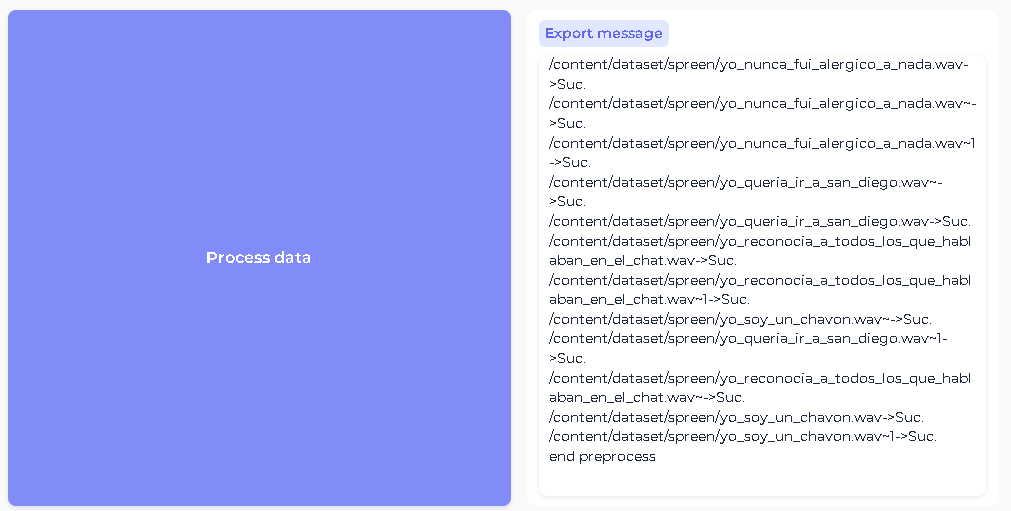

---

## Paso 2. Feauture extraction (Paciencia, es muuuy tardado)
Esperar a que aparezca **all-feature-done**

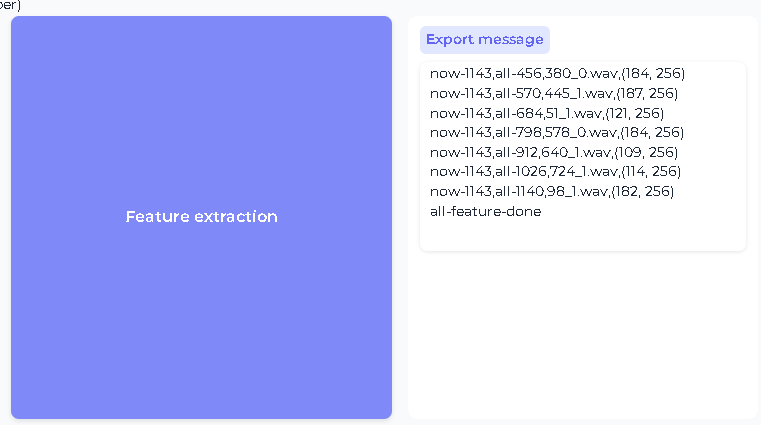

---

# Paso 3. Entrenar
Click en _train model_ y esperar que termine de completar las épocas

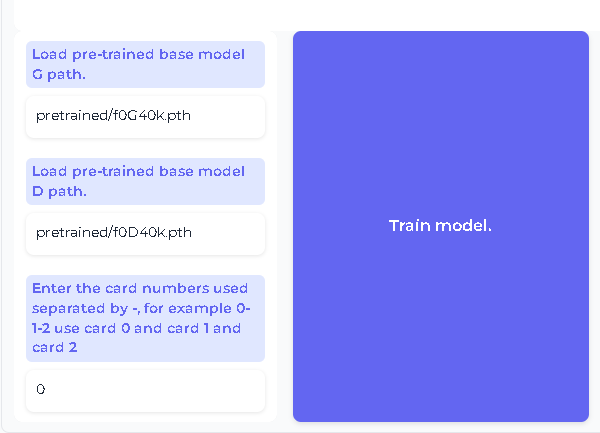

---

# Paso 4. Generar el archivo added{}.index
Click en _train feature index_ y esperar que muestre el mensaje de la derecha

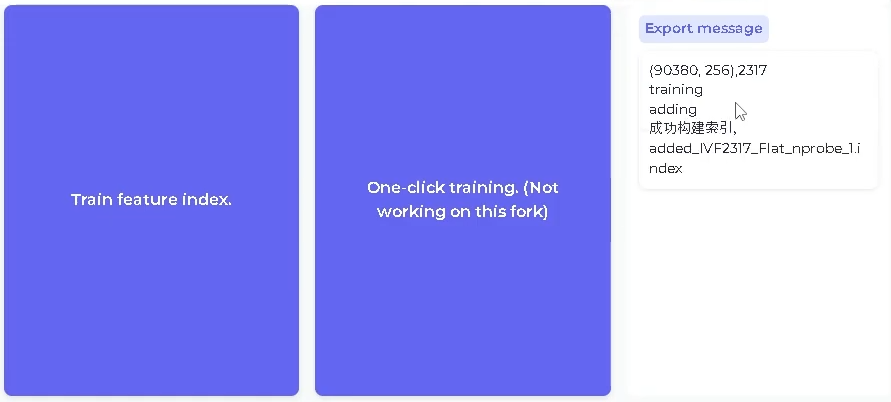